# Challenge: Feedback Analysis

We'll perform a sentiment analysis, classifying whether feedback left on a website is either positive or negative.

Pick one of the company data files and build your own classifier. When you're satisfied with its performance (at this point just using the accuracy measure shown in the example), test it on one of the other datasets to see how well these kinds of classifiers translate from one context to another.

Include your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [2]:
######### Imports ###########
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
####### Import Data #########
data = pd.read_csv('yelp_labelled.txt', delimiter= '\t', header=None)
data.columns = ['message', 'Positive?']
data.head()

,message,Positive?
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
message      1000 non-null object
Positive?    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


### Feature Engineering

Since this is yelp data, its important to understand the context in which something is good or bad. In the case of yelp, its reviews on restaurants, so there will be particular words associated with being positive.

Positive

In [4]:
###### Determine words most associated with Positive ######

#Goal: Want to create a list of words with counts

#First need to collect all the positive messages
positive = data[data['Positive?']==1]

full_list = []

#Create super list of all words
for sentence in data[data['Positive?']==1]['message'].tolist():
    words = sentence.split(' ')
    full_list.extend(words)
    
counts = Counter(full_list)

#Turn into Dataframe
positive_word_count = pd.DataFrame.from_dict(counts, orient='index')
positive_word_count.columns=['Count']

#Add length of word
positive_word_count['Length of word'] = positive_word_count.index.map(lambda x: len(x))

positive_word_count.sort_values(by=['Count'], inplace=True, ascending=False)
positive_word_count.head()

,Count,Length of word
and,218,3
the,214,3
was,137,3
I,113,1
a,107,1


Negative

In [9]:
###### Determine words most associated with Negative ######

#Goal: Want to create a list of words with counts

#First need to collect all the positive messages
positive = data[data['Positive?']==0]

full_list = []

#Create list of all words
for sentence in data[data['Positive?']==0]['message'].tolist():
    words = sentence.split(' ')
    full_list.extend(words)
    
counts = Counter(full_list)

#Turn into Dataframe
negative_word_count = pd.DataFrame.from_dict(counts, orient='index')
negative_word_count.columns=['Count']

#Add length of word
negative_word_count['Length of word'] = negative_word_count.index.map(lambda x: len(x))

negative_word_count.sort_values(by=['Count'], inplace=True, ascending=False)
negative_word_count.head()

,Count,Length of word
the,191,3
I,181,1
and,160,3
was,155,3
to,129,2


In [22]:
#Want to add Positivity and Negativty measures
#IS a particular word more associated with positive reviews vs negative reviews
def get_count(dataframe, index):
    try:
        return dataframe.loc[index]['Count']
    except:
        return 0

def calc_positivity(word):
    positive = get_count(positive_word_count, word)
    negative = get_count(negative_word_count, word)
    denominator = positive+negative
    
    if denominator == 0:
        return 0
    else:
        return (positive/(positive+negative))*100

def calc_negativity(word):
    positive = get_count(positive_word_count, word)
    negative = get_count(negative_word_count, word)
    denominator = positive+negative
    
    if denominator == 0:
        return 0
    else:
        return (negative/(positive+negative))*100

In [23]:
#Add measure to dataframes
positive_word_count['Positivity Percent'] = positive_word_count.index.map(lambda x: calc_positivity(x))
negative_word_count['Negativity Percent'] = negative_word_count.index.map(lambda x: calc_negativity(x))

In [20]:
######### Positive ###############
#Now can look at words over a certain length
positive_word_count[positive_word_count['Length of word']>=4].head(20).transpose()

,this,good,with,very,place,great,food,were,have,This,really,time,Great,service,they,here,that,friendly,like,just
Count,47.000000,42.0,41.000000,39.0,39.000000,37.0,37.00,34.000000,31.000000,29.000000,21.000000,19.000000,19.0,19.000000,19.0,18.0,18.000000,16.000000,16.000000,15.0
Length of word,4.000000,4.0,4.000000,4.0,5.000000,5.0,4.00,4.000000,4.000000,4.000000,6.000000,4.000000,5.0,7.000000,4.0,4.0,4.000000,8.000000,4.000000,4.0
Positivity Percent,49.473684,75.0,57.746479,65.0,51.315789,100.0,46.25,55.737705,52.542373,63.043478,67.741935,54.285714,100.0,46.341463,50.0,50.0,30.508475,88.888889,35.555556,50.0


In [24]:
######### Negative #############
#Now can look at words over a certain length
negative_word_count[negative_word_count['Length of word']>=5].head(20).transpose()

,place,service,don't,would,there,never,minutes,won't,wasn't,being,back.,think,going,food.,again.,their,really,which,about,because
Count,37.000000,22.000000,19.000000,19.0,15.000000,15.000000,14.0,13.000000,13.0,13.000000,13.000000,13.00,13.000000,11.000000,11.000000,11.000000,10.000000,10.000000,10.000000,10.000000
Length of word,5.000000,7.000000,5.000000,5.0,5.000000,5.000000,7.0,5.000000,6.0,5.000000,5.000000,5.00,5.000000,5.000000,6.000000,5.000000,6.000000,5.000000,5.000000,7.000000
Negativity Percent,48.684211,53.658537,86.363636,76.0,71.428571,83.333333,100.0,76.470588,100.0,92.857143,72.222222,81.25,72.222222,61.111111,73.333333,47.826087,32.258065,52.631579,58.823529,71.428571


In [33]:
####### Add Keywords #######
keywords = ['good', 'great', 'Great', 'friendly', 'love',
            'nice', 'loved', 'delicious!', 'amazing', 'excellent','fresh', 'never', 'being', 'minutes', 'wasn\'t']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    data[str(key)] = data.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [34]:
data.head()

,message,Positive?,Positivity Percent,good,great,Great,friendly,love,nice,loved,delicious!,amazing,excellent,fresh,never,being,minutes,wasn't
0,Wow... Loved this place.,1,0.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Crust is not good.,0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty.,0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,1,0.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,The selection on the menu was great and so wer...,1,0.0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False


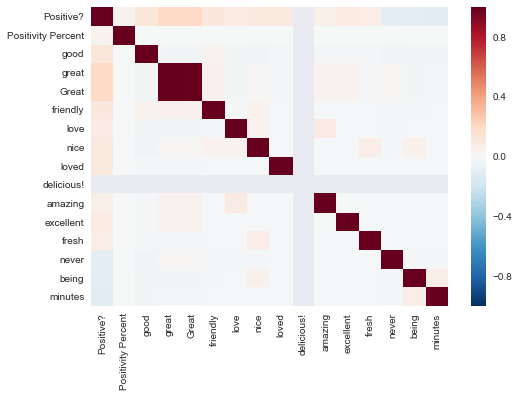

In [27]:
#Look at Correlation
sns.heatmap(data.corr())

### Create Model

In [35]:
#Create training data
training_data = data[keywords]
target = data['Positive?']

In [36]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(training_data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(training_data)

# Display our results.
print("Accuracy Score is : {}%".format(
    ((target == y_pred).sum()/training_data.shape[0])*100
))

Accuracy Score is : 62.0%


The BenoulliNB was the most accurate.

### Try on Different Dataset

In [96]:
####### Import Data #########
imdb_data = pd.read_csv('imdb_labelled.txt', delimiter= '\t', header=None)
imdb_data.columns = ['message', 'Positive?']


#Add Keywords
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb_data[str(key)] = imdb_data.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
imdb_data.head()

,message,Positive?,good,great,Great,friendly,love,nice,loved,delicious!,amazing,excellent,fresh,never
0,"A very, very, very slow-moving, aimless movie ...",0,False,False,False,False,False,False,False,False,False,False,False,False
1,Not sure who was more lost - the flat characte...,0,False,False,False,False,False,False,False,False,False,False,False,False
2,Attempting artiness with black & white and cle...,0,False,False,False,False,False,False,False,False,False,False,False,False
3,Very little music or anything to speak of.,0,False,False,False,False,False,False,False,False,False,False,False,False
4,The best scene in the movie was when Gerardo i...,1,False,False,False,False,False,False,False,False,False,False,False,False


In [97]:
#Create training data
imdb_training_data = imdb_data[keywords]
target_imdb = imdb_data['Positive?']

In [98]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(imdb_training_data)

# Display our results.

print("Accuracy Score is : {}%".format(
    ((target_imdb == y_pred).sum()/imdb_training_data.shape[0])*100
))

Accuracy Score is : 55.74866310160428%


This will have a lower accuracy score because the features were designed for the yelp reviews.